# Prediction of IMDB Ratings of movie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

## 1. Data Cleaning

In [2]:
df=pd.read_csv('IMDB-Movie-Data.csv')
df.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [3]:
director_text = df.Director.values
actor_text = df.Actors.values

In [4]:
#Extract all actor names from dataset
def build_actor_namelist():
    a = 0
    temp = Counter(actor_text).most_common()
    namelist = []
    while a in range(996):
        namelist = namelist + temp[a][0].split(',')
        a = a+1
    namelist = namelist + temp[0][0].split(',') + temp[1][0].split(',') + temp[2][0].split(',') + temp[3][0].split(',')
    actname_list = [word for (word, freq) in Counter(namelist).most_common(229)]
    return actname_list

In [5]:
actname_list = build_actor_namelist()

In [6]:
#Create actor feature matrix
def build_actor_matrix():
    temp = []
    a = 0
    while a < 1000:
        for name in df.loc[a,'Actors'].split(','):
            if name in actname_list:
                temp.append(name)
        if len(temp) >= 2:
            df.loc[a,'manyfamousactor'] = 1
        else:
            df.loc[a,'manyfamousactor'] = 0
        if len(temp) == 1:
            df.loc[a,'famousactor'] = 1
        else:
            df.loc[a,'famousactor'] = 0
        if len(temp) == 0:
            df.loc[a,'nofamousactor'] = 1
        else:
            df.loc[a,'nofamousactor'] = 0 
        temp = []
        a = a+1

In [7]:
build_actor_matrix()

In [8]:
#Create director feature feature matrix
def build_director_matrix():
    dirname_list = [word for (word, freq) in Counter(director_text).most_common(91)]
    df.famousdir = 0
    a = 0
    while a in range(1000):
        if df.loc[a,'Director'] in dirname_list:
            df.loc[a,'famousdir'] = 1
        else:
            df.loc[a,'famousdir'] = 0
        a = a+1

In [9]:
build_director_matrix()

In [10]:
#Convert runtime into binary class feature
def buildtimematrix():
    a = 0
    while a in range(1000):
        if df.loc[a,'Runtime (Minutes)'] <= 120:
            df.loc[a,'Runtime'] = 0
        else:
            df.loc[a,'Runtime'] = 1
        a = a+1

In [11]:
buildtimematrix()

In [12]:
#Create genre binary feature matrix
def build_genre_matrix():
    Genres = ['Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','History','Horror','Music','Mystery','Romance','Sci-Fi','Sport','Thriller','Western']
    for word in Genres:
        df[word] = 0
    num = 0
    while num < 1000:
        for word in Genres:
            if word in df.loc[num,'Genre']:
                df.loc[num,word] = 1
            else:
                df.loc[num,word] = 0
        num = num+1

In [13]:
build_genre_matrix()

In [14]:
#Convert ratings to binary labels
def build_target_list():
    y = []
    a = 0
    for a in range(1000):
        if df.loc[a,'Rating'] < 7:
            y.append(0)
        else:
            y.append(1)
    return y

In [51]:
# Get targets
y = build_target_list()
y[:10]

[1, 1, 1, 1, 0, 0, 1, 0, 1, 1]

In [16]:
#Drop extra columns
X = df.drop(['Rank','Title','Genre','Description','Director','Actors','Year','Rating','Votes',
           'Revenue (Millions)','Metascore','Runtime (Minutes)'],axis=1)
X.head()

,manyfamousactor,famousactor,nofamousactor,famousdir,Runtime,Action,Adventure,Animation,Biography,Comedy,...,Fantasy,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,Western
0,1.0,0.0,0.0,1.0,1.0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1.0,0.0,0.0,1.0,1.0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0.0,1.0,0.0,1.0,0.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1.0,0.0,0.0,0.0,0.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,0.0,1.0,1.0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [17]:
#Divide dataset into training (including validate sets) and test sets
X_train,y_train = X[:800], y[:800]
X_test,y_test = X[800:], y[800:]

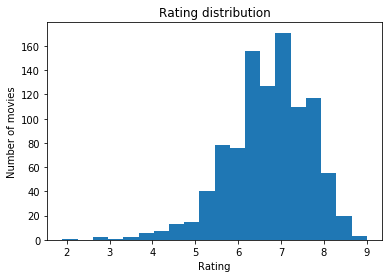

In [18]:
# Check distribution of targets
plt.hist(df['Rating'],bins = 20)
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Number of movies')
plt.show()

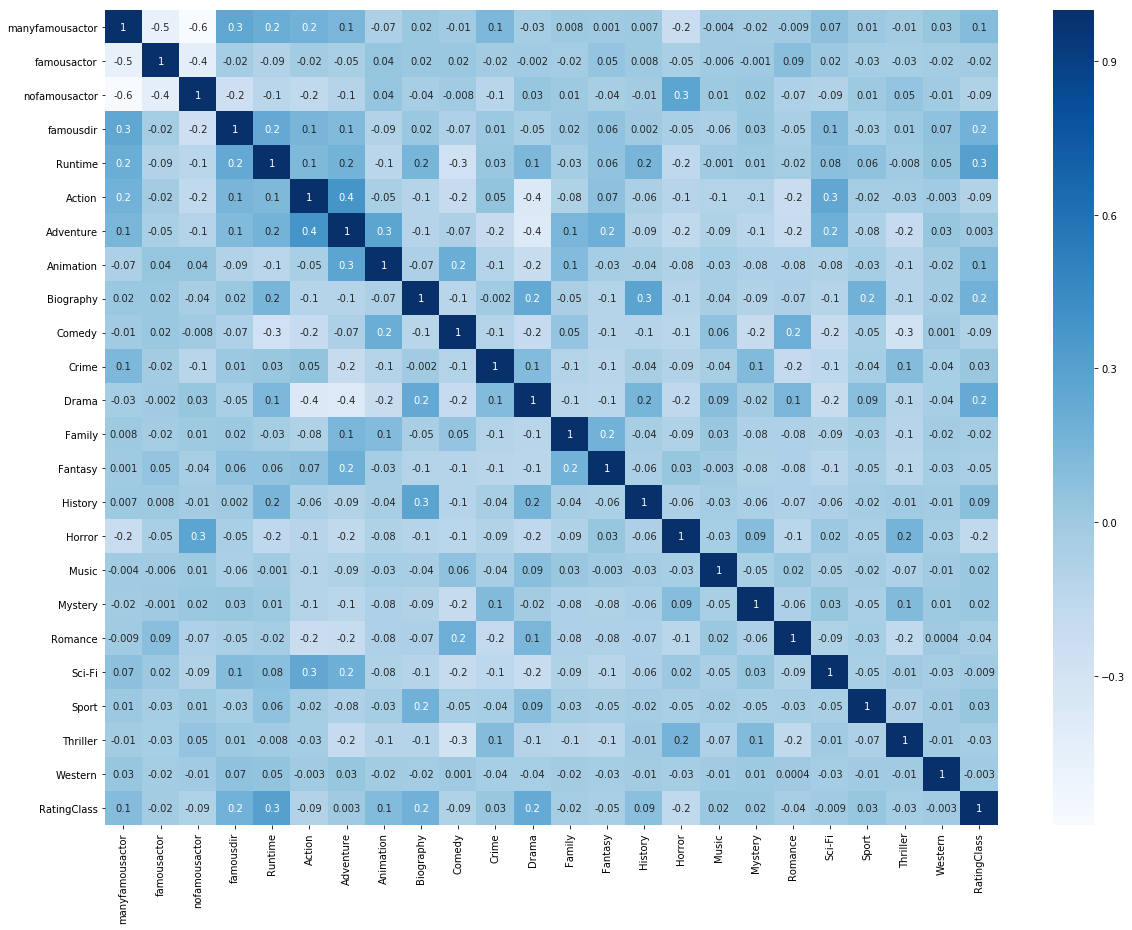

In [19]:
# Glance at data correlation
feature_df = pd.concat([X,pd.DataFrame(data = y,columns = ['RatingClass'])],axis = 1)
plt.figure(figsize = (20,15))
g = sns.heatmap(feature_df.corr(),fmt = '.1g',annot=True,cmap = "Blues")

## 2. Build baseline models

### 2.1 Logistic Regression parameters tuning

In [20]:
# C tuning for L1 and L2 regularizer
def C_tuning(X, y, classifier):
    result_list = []
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=7)
    
    for param in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300,1000]:
        if classifier == 'LR_L1':
            clf = LogisticRegression(C = param, penalty='l1', solver='liblinear').fit(X_train, y_train)
        if classifier == 'LR_L2':
            clf = LogisticRegression(C = param, penalty='l2', solver='lbfgs').fit(X_train, y_train)
        
        y_train_predict = clf.predict_proba(X_train)[:,1] #get probability prediction of positive class
        y_validate_predict = clf.predict_proba(X_validate)[:,1]
        train_roc_auc_score = roc_auc_score(y_train, y_train_predict)
        validate_roc_auc_score = roc_auc_score(y_validate, y_validate_predict)
        result_list.append((param, train_roc_auc_score, validate_roc_auc_score))
    result_df = pd.DataFrame(result_list, columns=["param", "train_roc_auc_score", "validate_roc_auc_score"])
    
    return result_df

In [21]:
def plot_roc_auc_score(X, y, classifier):
    param_df = C_tuning(X, y,classifier)
    param_df.plot(x = 'param', y=["train_roc_auc_score", "validate_roc_auc_score"], logx=True).set_xlabel('C')

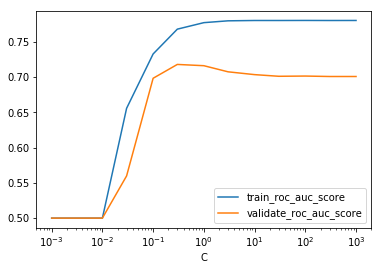

In [22]:
plot_roc_auc_score(X_train,y_train,'LR_L1')

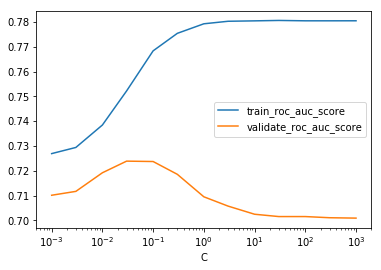

In [23]:
plot_roc_auc_score(X_train, y_train, 'LR_L2')

### 2.2 Tree-based classifier parameters tuning

In [24]:
def EstimatorDepth_tuning(X, y, classifier, tuning_param):
    result_list = []
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=7)
    
    if tuning_param == 'n_estimators':
        for estimatorNum in [3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
            if classifier == 'RFC':
                clf = RandomForestClassifier(n_estimators = estimatorNum, max_depth = 2, n_jobs =-1).fit(X_train, y_train)
            if classifier == 'XGB':
                clf = XGBClassifier(n_estimators = estimatorNum, max_depth = 2, n_jobs =-1).fit(X_train, y_train)
            param = estimatorNum
            y_train_predict = clf.predict_proba(X_train)[:,1] #get probability prediction of positive class
            y_validate_predict = clf.predict_proba(X_validate)[:,1]
            train_roc_auc_score = roc_auc_score(y_train, y_train_predict)
            validate_roc_auc_score = roc_auc_score(y_validate, y_validate_predict)
            result_list.append((param, train_roc_auc_score, validate_roc_auc_score))
    
    if tuning_param == 'max_depth':
        for depth in [2, 4, 6, 8, 10]:
            if classifier == 'RFC':
                clf = RandomForestClassifier(n_estimators = 10, max_depth = depth, n_jobs =-1).fit(X_train, y_train)
            if classifier == 'XGB':
                clf = XGBClassifier(n_estimator = 10, max_depth = depth, n_jobs =-1).fit(X_train, y_train)
            param = depth
            y_train_predict = clf.predict_proba(X_train)[:,1] #get probability prediction of positive class
            y_validate_predict = clf.predict_proba(X_validate)[:,1]
            train_roc_auc_score = roc_auc_score(y_train, y_train_predict)
            validate_roc_auc_score = roc_auc_score(y_validate, y_validate_predict)
            result_list.append((param, train_roc_auc_score, validate_roc_auc_score))
   
    result_df = pd.DataFrame(result_list, columns=[tuning_param, "train_roc_auc_score", "validate_roc_auc_score"])
    
    return result_df

In [25]:
def plot_roc_auc_score2(X, y, classifier, tuning_param):
    param_df = EstimatorDepth_tuning(X, y,classifier, tuning_param)
    param_df.plot(x = tuning_param, y=["train_roc_auc_score", "validate_roc_auc_score"]).set_xlabel(tuning_param)

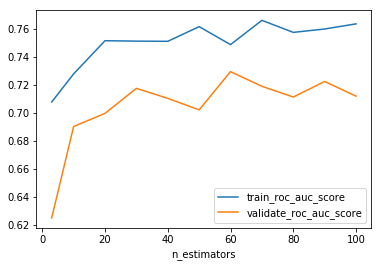

In [47]:
plot_roc_auc_score2(X_train, y_train, 'RFC', 'n_estimators')

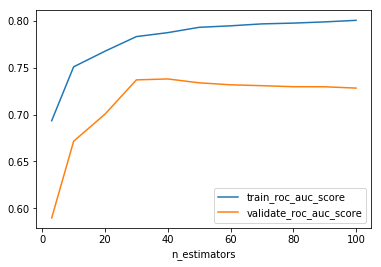

In [27]:
plot_roc_auc_score2(X_train, y_train, 'XGB', 'n_estimators')

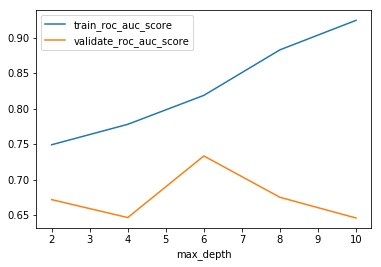

In [28]:
plot_roc_auc_score2(X_train, y_train, 'RFC', 'max_depth')

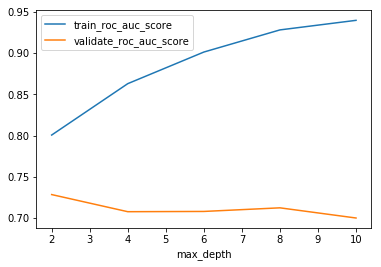

In [29]:
plot_roc_auc_score2(X_train, y_train, 'XGB', 'max_depth')

In [30]:
def TunedModel():
    LR_L1 = LogisticRegression(C=0.1,solver='liblinear',penalty='l1')
    LR_L2 = LogisticRegression(C=0.03,solver='lbfgs',penalty='l2')
    RFC = RandomForestClassifier(n_estimators = 10, max_depth = 4, n_jobs =-1)
    XGB = XGBClassifier(n_estimator=30,max_depth = 2, n_jobs =-1)
    return LR_L1, LR_L2, RFC, XGB

### 2.3 Feature importance and coefficients

In [31]:
# plot coefficients of logistic regression models
def coef_plot(coef):
    featureDf=pd.DataFrame(list(zip(X.columns.values,coef[0])),columns=['feature','coefficent']).sort_values('coefficent')
    featureDf=featureDf.loc[featureDf['coefficent']!=0].set_index('feature')
    featureDf.plot(kind='barh')
    plt.show()

In [32]:
# plot feature importance of models
def plot_feature_importance(classifier):
    clf = classifier.fit(X_train, y_train)
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()

In [33]:
LR_L1, LR_L2, RFC, XGB = TunedModel()

In [34]:
LR_L1_coef = LR_L1.fit(X_train,y_train).coef_
LR_L2_coef = LR_L2.fit(X_train,y_train).coef_

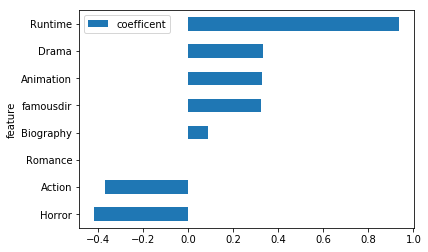

In [35]:
coef_plot(LR_L1_coef)

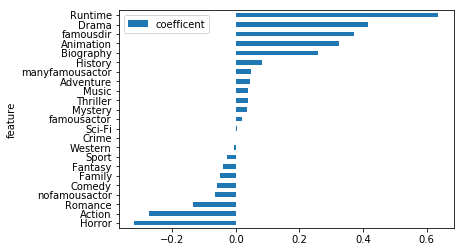

In [36]:
coef_plot(LR_L2_coef)

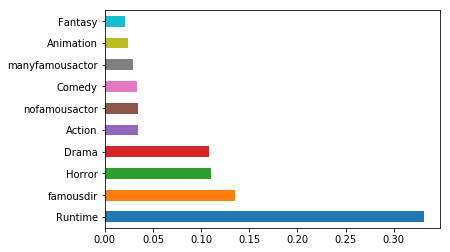

In [37]:
plot_feature_importance(RFC)

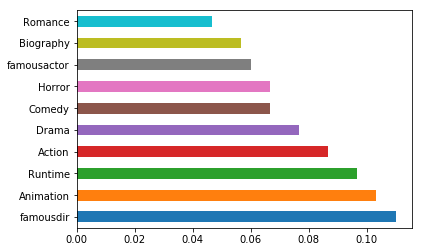

In [38]:
plot_feature_importance(XGB)

## 3. Models Evaluation

### 3.1 Confusion matrix

In [39]:
#Build confusion matrix based on K-fold crossvalidation results
def build_cm(classifier):
    cm_list = []
    clf = classifier.fit(X_train, y_train) 
    y_test_predict = clf.predict(X_test)
    cm_list.append(confusion_matrix(y_test, y_test_predict))
    combined_cm = pd.DataFrame(sum(cm_list))
    return combined_cm

In [40]:
#Plot confusion matrix 
def plot_cm(classifier):
    cm = build_cm(classifier)
    plt.figure(figsize = (4,4))
    rg = sns.heatmap(cm,annot = True,fmt='g',cmap='Blues')

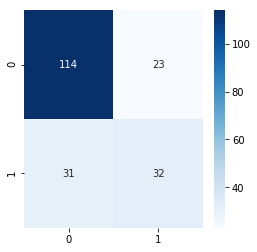

In [41]:
plot_cm(LR_L1)

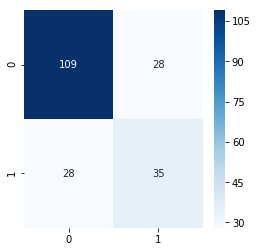

In [42]:
plot_cm(LR_L2)

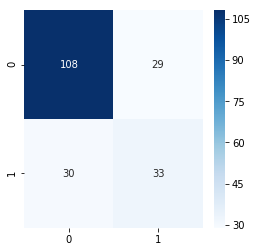

In [43]:
plot_cm(RFC)

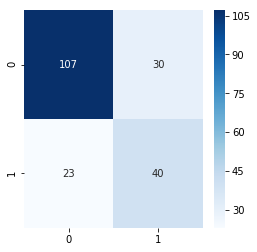

In [44]:
plot_cm(XGB)

### 3.2 ROC_AUC_Curve

In [45]:
def roc_auc_curvePlot():
    tprs = []
    aucs = []
    for iteration in range(4):
        classifier = [LR_L1, LR_L2, RFC, XGB]
        clf_name = ['LR_L1', 'LR_L2', 'RFC', 'XGB']
        clf = classifier[iteration].fit(X_train,y_train)
        mean_fpr = np.linspace(0, 1, 100)
        probas_ = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw = 2, alpha = 0.8,
                 label = 'ROC %s (AUC = %0.2f)' %  (clf_name[iteration], roc_auc))
    plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r',
             label = 'Chance', alpha = .8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()

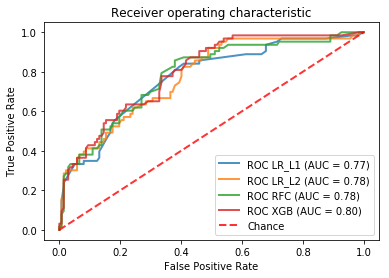

In [46]:
roc_auc_curvePlot()